# Cell segmentation using CellPose
- Version: 0.2.5
- Last update: 2023.10.31
- Author: Yu-Le Wu

This notebook segments cells in give FOVs using CellPose. There are two parts:
1. Image processing: all membrane channels are first contrast enhanced and combined. The nulei channel is simply contrast enhanced. 
2. The processed images are then loaded and subjet to CellPose.

## import requried packages
This part can take a while (a few minutes)

In [1]:
import tifffile
import os
import cv2
import numpy as np
import seaborn_image as isns
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage import exposure

# Define basic information
## Defining the working directory
The base_dir should be the one where the folder image_data is

In [2]:
base_dir = "../Data"
project_name = "SMP2023"

In [7]:
os. chdir(base_dir)
imageData_dir = os.path.join(base_dir, project_name, "image_data")
FOVs = os.listdir(imageData_dir)

# This part then detects the subfolder like 'rescaled' 
FOVs = [item for item in FOVs if os.path.isdir(os.path.join(imageData_dir, item))]
FOVs = sorted(FOVs)

## Defining the membrane channels
These channels will be merged into a new channel *membrane_sum*
- membrane_channels: a list of channel names
- qt: a value between 0 and 1. qt is used to saturate the images. For example, a value of 0.99 will rescale all pixels linearly to make the 99th quantile and above the maximum 

In [9]:
membrane_channels = ['membrane','GLUT1','ASCT2']
nuclei_channel = ['nuclei']


## Image normalization and image generation 

Here each channels defined above will be normalized by a user defined quantile `qt` per image. Everything above `qt` we be set to `qt`.
Normalized channels will then be combined and the combined channels will be normalized again in the same way.

In [ ]:
qt = 0.9965 # user-defined quantile

In [74]:
targetDir = os.path.join(base_dir, project_name, 'cellpose_input')

os.makedirs(targetDir, exist_ok=True)

for oneFOV in FOVs:
    folderPath = os.path.join(imageData_dir, oneFOV)
    files = os.listdir(folderPath)

    for k, ch in enumerate(membrane_channels):
        img = tifffile.imread(os.path.join(folderPath, ch + '.tiff'))
        if k == 0:
            dim = np.shape(img)
            membrane_sum = np.zeros(tuple([1]) + dim, dtype=np.uint8)
        q = np.quantile(img, qt)
        img = exposure.rescale_intensity(img, in_range=(0, q))
        membrane_sum = np.concatenate((membrane_sum, img[None,...]))

    # max intensity projection
    membrane_sum = np.max(membrane_sum, axis=0)
    
    q = np.quantile(membrane_sum,qt)
    membrane_sum_normalized = exposure.rescale_intensity(membrane_sum, in_range=(0, q))
    #membrane_sum_normalized = exposure.exposure.equalize_hist(membrane_sum_normalized)

    # Change the Nucleus tiff file here if it is named differently
    for k, ch in enumerate(nuclei_channel):
        img = tifffile.imread(os.path.join(folderPath, ch + '.tiff'))

        if k == 0:
            dim = np.shape(img)
            nu_sum = np.zeros(tuple([1]) + dim, dtype=np.uint8)
        q = np.quantile(img, qt)
        img = exposure.rescale_intensity(img, in_range=(0, q))
        nu_sum = np.concatenate((nu_sum, img[None,...]))

    # max intensity projection
    nu_sum = np.max(nu_sum, axis=0)
    
    q = np.quantile(nu_sum,qt)
    nu_sum[nu_sum > q] = q
    nu_sum_normalized = exposure.rescale_intensity(nu_sum, in_range=(0, q))
    #nu_sum_normalized = exposure.exposure.equalize_hist(nu_sum_normalized)

    os.makedirs(targetDir, exist_ok=True)
    cell = np.stack((nu_sum_normalized, membrane_sum_normalized), axis = 0)
    tifffile.imwrite(os.path.join(targetDir, oneFOV + '_membrane_sum_proc.tiff'), membrane_sum_normalized, shape=membrane_sum_normalized.shape)
    tifffile.imwrite(os.path.join(targetDir, oneFOV + '_nuclei_channel_proc.tiff'), nu_sum_normalized, shape=nu_sum_normalized.shape)
    # 2023.08.05: now the "cell" will not appear in the file name anymore
    tifffile.imwrite(os.path.join(targetDir, oneFOV + '.tiff'), cell, shape=cell.shape)

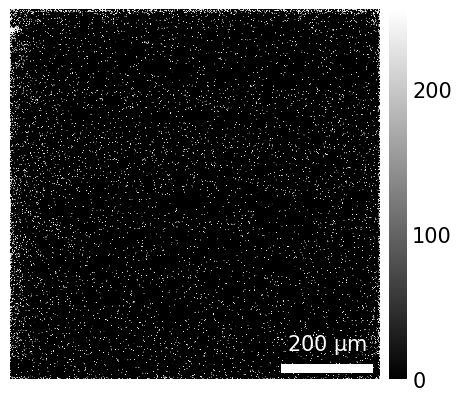

In [6]:
isns.set_context("notebook")
# change image related settings
isns.set_image(cmap="gray", despine=True)  # set the colormap and despine the axes
isns.set_scalebar(color="white")  # change scalebar color
# image with a scalebar

ax = isns.imgplot(membrane_sum_normalized, dx=0.39, units="um")

## Segmentation
>**WARNING: the imsave() part has not been tested!**

The mean cell diameter is a key parameter to optimal segmentation. However, from my experience, the estimated diameter provided by Cellpose is not working well. Therefore, I came up with this idea to minimize the difference between the mean diameter we put and the mean diameter of the final masks. This is currently simply done by trying a couple of different diameters.

### Options for the segmentation
- which_to_segment: a two-element array. The two elements correspond to *whole cell* and *nuclei*
- model_type: a string that corresponds to the pre-trained models Cellpose supplied
- dia: defining the range of diameters to be tested in pixels
- cellprob_threshold: a value between -6 and 6, the smaller the more ROIs you get
- flow_threshold: a value, the higher the more ROIs you get. 0 means keeping all the masks

Check out https://cellpose.readthedocs.io/en/latest/settings.html#settings for more details

In [13]:
which_to_segment = [True, True]
model_folder = '/omics/groups/OE0622/internal/cellpose/models'
model_type = 'TN2'
dia = range(15,50,5)
pxSize = 100
keywords = ['CB','CSL']
cellprob_threshold = -6
flow_threshold = 0

In [14]:
# This is the actual part of the segmentation
pxFactor = round(500/pxSize)

# Load the respective models
model = models.CellposeModel(pretrained_model=os.path.join(model_folder, model_type))
model_nu = models.CellposeModel(pretrained_model=os.path.join(model_folder, 'nucleitorch_0'))

# Looping through all the FOVs
srcDir = os.path.join(base_dir, 'cellpose_input')
targetDir = os.path.join(base_dir, 'cellpose_output')

os.makedirs(targetDir, exist_ok=True)

# reading an image
idx_min = np.zeros(len(keywords), dtype = 'uint32')

firstFOV_with_keyword = []
# Check if fov contains all keywords
for keyword in keywords:
    for k, FOV in enumerate(FOVs):
        if keyword in FOV:
            firstFOV_with_keyword.append(k)
            break


In [15]:
for k, keyword in enumerate(keywords):
    if which_to_segment[0]:
        oneFOV = FOVs[firstFOV_with_keyword[k-1]]
        imgs = imread(srcDir + '/' + oneFOV + '.tiff')
        dim = np.shape(imgs)
    
        nCell = []
        dia_result = []
        masks = []

        # trying a couple of diameters
        for diai in dia:

            # segmenting
            mask, flow, style = model.eval(imgs, diameter=diai*pxFactor, channels=[2,1], flow_threshold=flow_threshold, cellprob_threshold = cellprob_threshold, do_3D=False)
            mask = np.reshape(mask, (1,)+ dim[1:3])
            imsave(os.path.join(targetDir, oneFOV + '_whole_cell_dia_${:.0f}px.tiff'.format(diai*pxFactor)), mask, check_contrast=False)

            if len(masks)==0:
                masks = mask
            else:
                masks = np.concatenate((masks, mask), axis = 0)

            cellID, pixels_per_cell = np.unique(mask, return_counts=True)
            pixels_per_cell = pixels_per_cell[1:]
            meanArea = pixels_per_cell.mean()
            r = (meanArea/np.pi)**0.5
            dia_result.append(r*2)
            nCell.append(len(pixels_per_cell))

        # take the best match as the final output
        idx_min[k] = np.argmin(np.abs(np.array(dia_result)-np.array([x * pxFactor for x in dia])))


In [16]:
for oneFOV in FOVs:
    
    # reading an image
    imgs = imread(srcDir + '/' + oneFOV + '.tiff')
    dim = np.shape(imgs)

    if which_to_segment[0]:
        nCell = []
        dia_result = []
        masks = []

        # trying a couple of diameters
        for i, keyword in enumerate(keywords):
            if keyword in oneFOV:
                diai = dia[idx_min[i]]
                break
            
        # segmenting
        mask, flow, style = model.eval(imgs, diameter=diai*pxFactor, channels=[2,1],
                                             flow_threshold=flow_threshold, cellprob_threshold = cellprob_threshold, do_3D=False)
        mask = np.reshape(mask, (1,)+ dim[1:3])
        imsave(os.path.join(targetDir, oneFOV + '_whole_cell.tiff'), mask, check_contrast=False)
        
    if which_to_segment[1]:
        # For nuclei
        mask_nu, flow_nu, style_nu = model_nu.eval(imgs, diameter=15*pxFactor, channels=[1,0],
                                             flow_threshold=0, cellprob_threshold = -6, do_3D=False)
        mask_nu = np.reshape(mask_nu,(1,) + dim[1:3])
        imsave(os.path.join(targetDir, oneFOV + '_nuclear.tiff'), mask_nu, check_contrast=False)